## Importing Library

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
import lightgbm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
import joblib
from datetime import datetime
from prettytable import PrettyTable
from tensorflow.keras import backend as K
import shutil,os
import pickle

## Loading Data

In [2]:
#pjm_final = pd.read_pickle("final_pjm_data.pkl")
pjm_final = pd.read_pickle("final_pjm_stationary.pkl")
pjm_final.head(2)

,PJME_MW,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
Datetime,,,,,,
2002-01-08 03:00:00,10.253299,0.468011,0.707107,0.486405,0.707107,0.556635
2002-01-08 04:00:00,10.259167,0.460879,0.500000,0.468011,0.866025,0.560467


In [3]:
pjm_df_copy = pjm_final.copy()
#pjm_df_copy = pjm_df_copy.reset_index()
#pjm_df_copy = pjm_df_copy.drop('Datetime',axis=1)
pjm_df_copy.head(2)

,PJME_MW,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
Datetime,,,,,,
2002-01-08 03:00:00,10.253299,0.468011,0.707107,0.486405,0.707107,0.556635
2002-01-08 04:00:00,10.259167,0.460879,0.500000,0.468011,0.866025,0.560467


In [4]:
X = pjm_df_copy.drop(['PJME_MW'],axis=1)
y = pjm_df_copy['PJME_MW'].values

print('Shape of X :',X.shape)
print('Shape of y :',y.shape)

Shape of X : (145132, 5)
Shape of y : (145132,)


## Loading Best Model (Random Forest)

In [5]:
%%time
random_forest_reg = joblib.load("random_forest.joblib")

Wall time: 5min 1s


In [6]:
# Predictions on data
random_fst_prediction=random_forest_reg.predict(X)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   27.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   43.1s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 874 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 1144 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done 1250 out of 1250 | elapsed:  5.4min finished


## Creating DataFrame with all predictions

In [7]:
predicted_df = pd.DataFrame(X)
predicted_df.head(2)

,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean
Datetime,,,,,
2002-01-08 03:00:00,0.468011,0.707107,0.486405,0.707107,0.556635
2002-01-08 04:00:00,0.460879,0.500000,0.468011,0.866025,0.560467


In [8]:
# Adding columns - actual/true value and predicted value
predicted_df['True_Y'] = np.round_(y,2)
predicted_df['Predicted_Y'] = np.round_(random_fst_prediction,2)
print('Shape of new predicted dataframe :',predicted_df.shape)

Shape of new predicted dataframe : (145132, 7)


In [9]:
predicted_df
predicted_df.head()

,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean,True_Y,Predicted_Y
Datetime,,,,,,,
2002-01-08 03:00:00,0.468011,7.071068e-01,0.486405,0.707107,0.556635,10.25,10.25
2002-01-08 04:00:00,0.460879,5.000000e-01,0.468011,0.866025,0.560467,10.26,10.26
2002-01-08 05:00:00,0.464925,2.588190e-01,0.460879,0.965926,0.564586,10.28,10.29
2002-01-08 06:00:00,0.482082,6.123234e-17,0.464925,1.000000,0.568815,10.35,10.35
2002-01-08 07:00:00,0.529593,-2.588190e-01,0.482082,0.965926,0.573248,10.47,10.47


### Creating Dataframe and counting number of correct and incorrect prediction

we will compare true value and predicted value since the time series data has to be made stationary for doing all modelling using log transform as without transformation model will not work properly and the feature are also obtained by transformation, thus the value lies between 9-11 thus choosing threshold value will be difficult and result will become weired <br>
Comparing the true and predicted value on transformed is working well.

In [10]:
correct_prediction = predicted_df[predicted_df['True_Y'] == predicted_df['Predicted_Y']]
incorrect_prediction = predicted_df[predicted_df['True_Y'] != predicted_df['Predicted_Y']]

In [11]:
print('Total number of correct prediction :',len(correct_prediction))
print('Total number of incorrect prediction :',len(incorrect_prediction))

Total number of correct prediction : 107133
Total number of incorrect prediction : 37999


##### Dataframe for Correctly Prediction

In [12]:
Correct_df = correct_prediction.copy()
Correct_df.head()

,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean,True_Y,Predicted_Y
Datetime,,,,,,,
2002-01-08 03:00:00,0.468011,7.071068e-01,0.486405,0.707107,0.556635,10.25,10.25
2002-01-08 04:00:00,0.460879,5.000000e-01,0.468011,0.866025,0.560467,10.26,10.26
2002-01-08 06:00:00,0.482082,6.123234e-17,0.464925,1.000000,0.568815,10.35,10.35
2002-01-08 07:00:00,0.529593,-2.588190e-01,0.482082,0.965926,0.573248,10.47,10.47
2002-01-08 09:00:00,0.659407,-7.071068e-01,0.612155,0.707107,0.581975,10.53,10.53


##### Dataframe for Incorrectly Prediction

In [13]:
Incorrect_df = incorrect_prediction.copy()
Incorrect_df.head()

,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean,True_Y,Predicted_Y
Datetime,,,,,,,
2002-01-08 05:00:00,0.464925,0.258819,0.460879,9.659258e-01,0.564586,10.28,10.29
2002-01-08 08:00:00,0.612155,-0.500000,0.529593,8.660254e-01,0.577657,10.54,10.53
2002-01-08 10:00:00,0.651637,-0.866025,0.659407,5.000000e-01,0.586194,10.51,10.52
2002-01-08 11:00:00,0.640620,-0.965926,0.651637,2.588190e-01,0.589837,10.51,10.50
2002-01-08 12:00:00,0.634601,-1.000000,0.640620,1.224647e-16,0.592211,10.48,10.49


## EDA on above two dataframes

### 1.Descriptive statistics for correct and incorrect prediction

In [14]:
Correct_df.describe()

,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean,True_Y,Predicted_Y
count,107133.000000,1.071330e+05,107133.000000,1.071330e+05,107133.000000,107133.000000,107133.000000
mean,0.529693,-1.834723e-02,0.531388,2.590858e-02,0.505329,10.351100,10.351100
std,0.138213,7.163778e-01,0.136966,6.969966e-01,0.140554,0.201411,0.201411
min,0.013010,-1.000000e+00,0.000000,-1.000000e+00,0.000322,9.650000,9.650000
25%,0.434952,-7.071068e-01,0.438526,-7.071068e-01,0.401052,10.210000,10.210000
50%,0.528492,-1.836970e-16,0.530296,1.224647e-16,0.492378,10.350000,10.350000
75%,0.618198,7.071068e-01,0.619011,7.071068e-01,0.602583,10.480000,10.480000
max,0.997627,1.000000e+00,1.000000,1.000000e+00,0.999897,11.030000,11.030000


In [15]:
Incorrect_df.describe()

,lag_feature1,hour_cos_feature,lag_feature2,hour_sin_feature,rolling_day_mean,True_Y,Predicted_Y
count,37999.000000,3.799900e+04,37999.000000,37999.000000,37999.000000,37999.000000,37999.000000
mean,0.538913,5.029425e-02,0.534079,-0.074876,0.503077,10.372099,10.372087
std,0.127728,6.779351e-01,0.131743,0.729585,0.139357,0.181659,0.180849
min,0.000000,-1.000000e+00,0.001989,-1.000000,0.000000,9.590000,9.600000
25%,0.458395,-5.000000e-01,0.448495,-0.866025,0.401516,10.260000,10.260000
50%,0.538532,6.123234e-17,0.533716,-0.258819,0.490629,10.370000,10.370000
75%,0.618498,7.071068e-01,0.616106,0.707107,0.595634,10.490000,10.490000
max,1.000000,1.000000e+00,0.998887,1.000000,1.000000,11.040000,11.030000


##### Observation:
It can be seen there are differences in  mean,max,median values when comparing correctly and incorrectly predicted datsets

### 2.Looking the series plot of year 2016 for correctly and incorrectly predictions separately

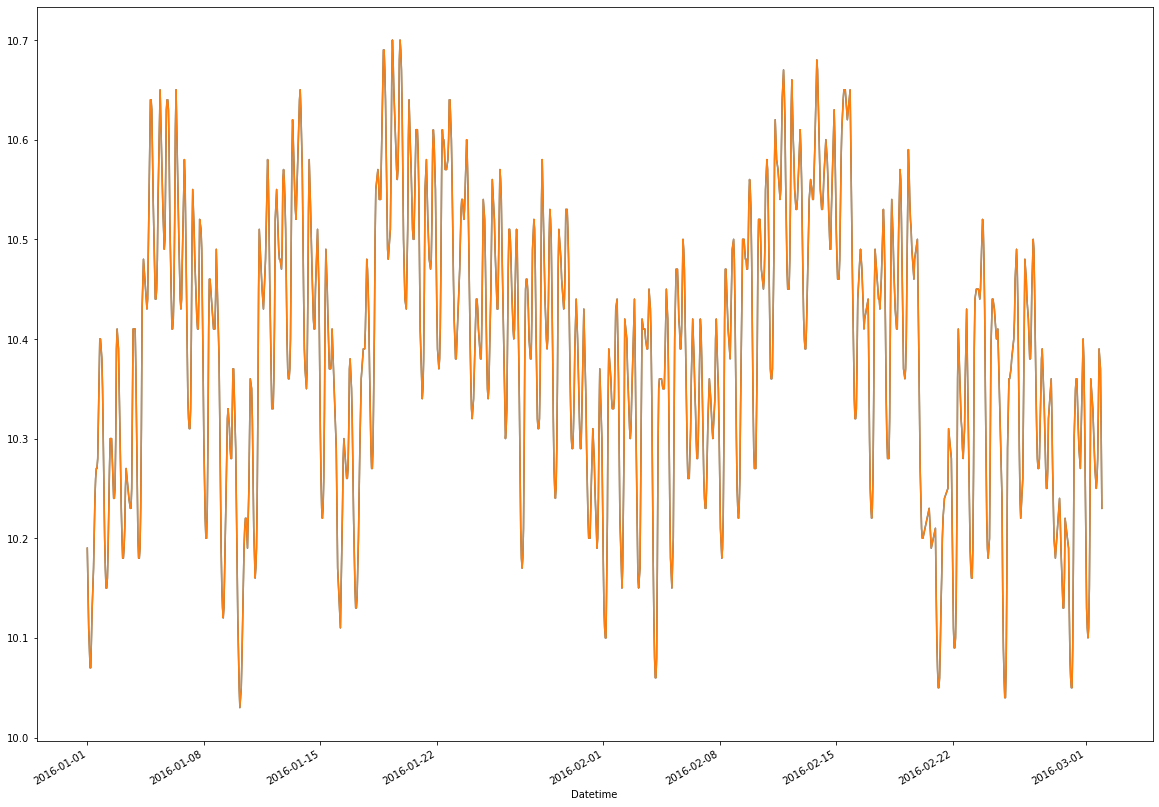

In [37]:
year_2016 = Correct_df.loc['2016-01-01':'2016-03-01','True_Y'].plot(figsize=(20,15))
year_2016 = Correct_df.loc['2016-01-01':'2016-03-01','Predicted_Y'].plot(figsize=(20,15))


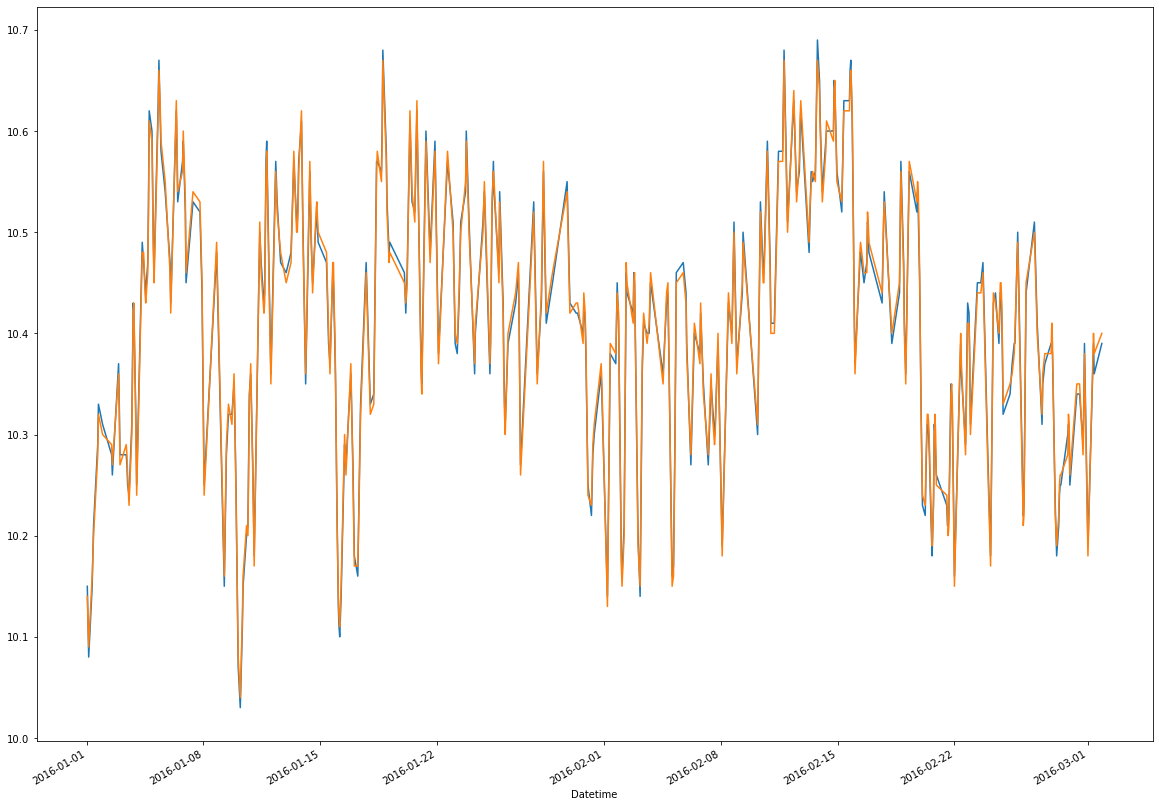

In [35]:
year_2016 = Incorrect_df.loc['2016-01-01':'2016-03-01','True_Y'].plot(figsize=(20,15))
year_2016 = Incorrect_df.loc['2016-01-01':'2016-03-01','Predicted_Y'].plot(figsize=(20,15))

##### Observation:
From the above two plots we can clearly see the weekly variation or oscillations of energy consumption<br>
In the First Plot ,which is Correctly predicted dataframe,the true value and predicted value and merged very well<br>
Whereas in Incorrectly predicted dataframe we can see the true value and predicted value are not merged completely,we can see peaks and valleys points of blue and orange.


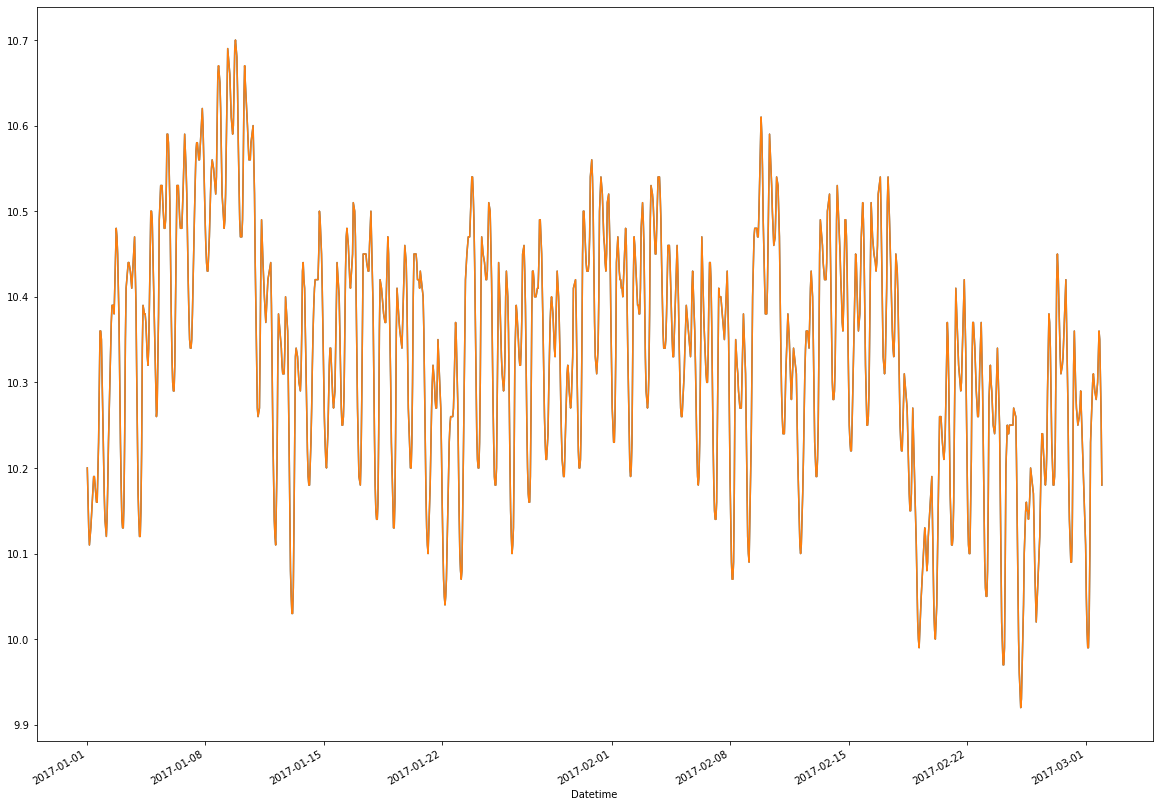

In [38]:
year_2017 = Correct_df.loc['2017-01-01':'2017-03-01','True_Y'].plot(figsize=(20,15))
year_2017 = Correct_df.loc['2017-01-01':'2017-03-01','Predicted_Y'].plot(figsize=(20,15))

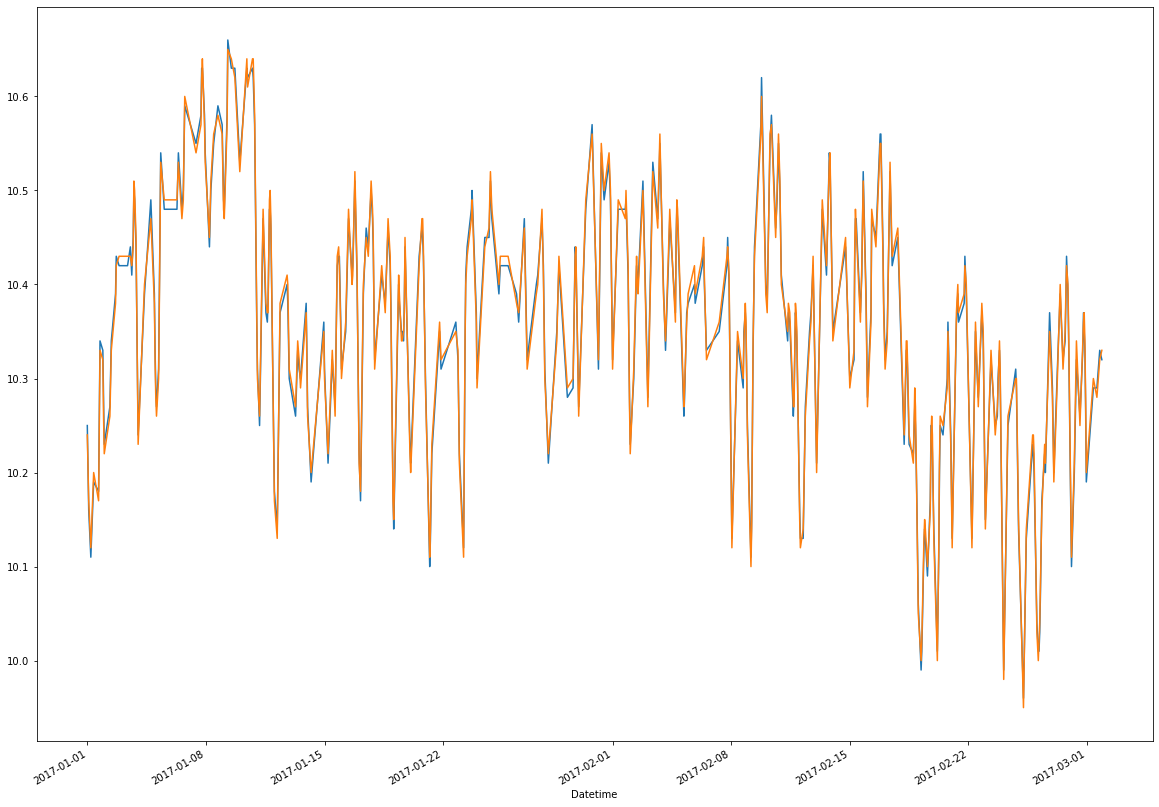

In [39]:
year_2017 = Incorrect_df.loc['2017-01-01':'2017-03-01','True_Y'].plot(figsize=(20,15))
year_2017 = Incorrect_df.loc['2017-01-01':'2017-03-01','Predicted_Y'].plot(figsize=(20,15))

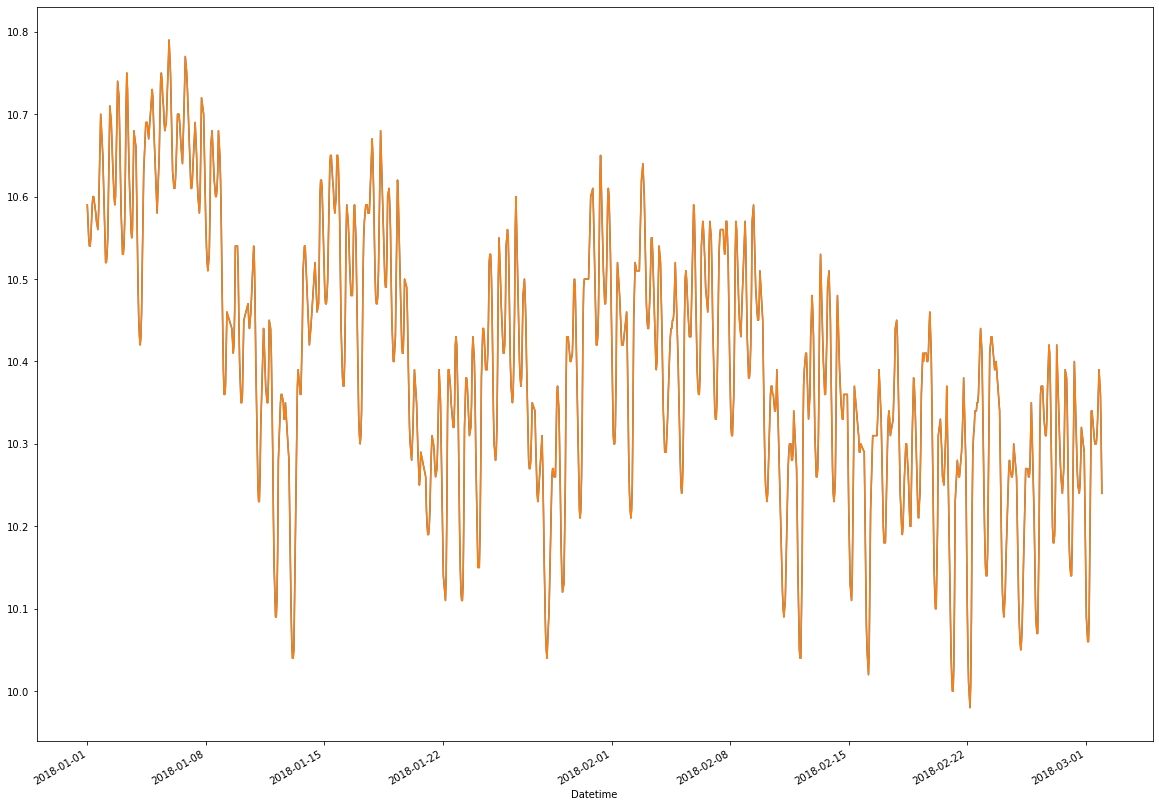

In [41]:
year_2018 = Correct_df.loc['2018-01-01':'2018-03-01','True_Y'].plot(figsize=(20,15))
year_2018 = Correct_df.loc['2018-01-01':'2018-03-01','Predicted_Y'].plot(figsize=(20,15))

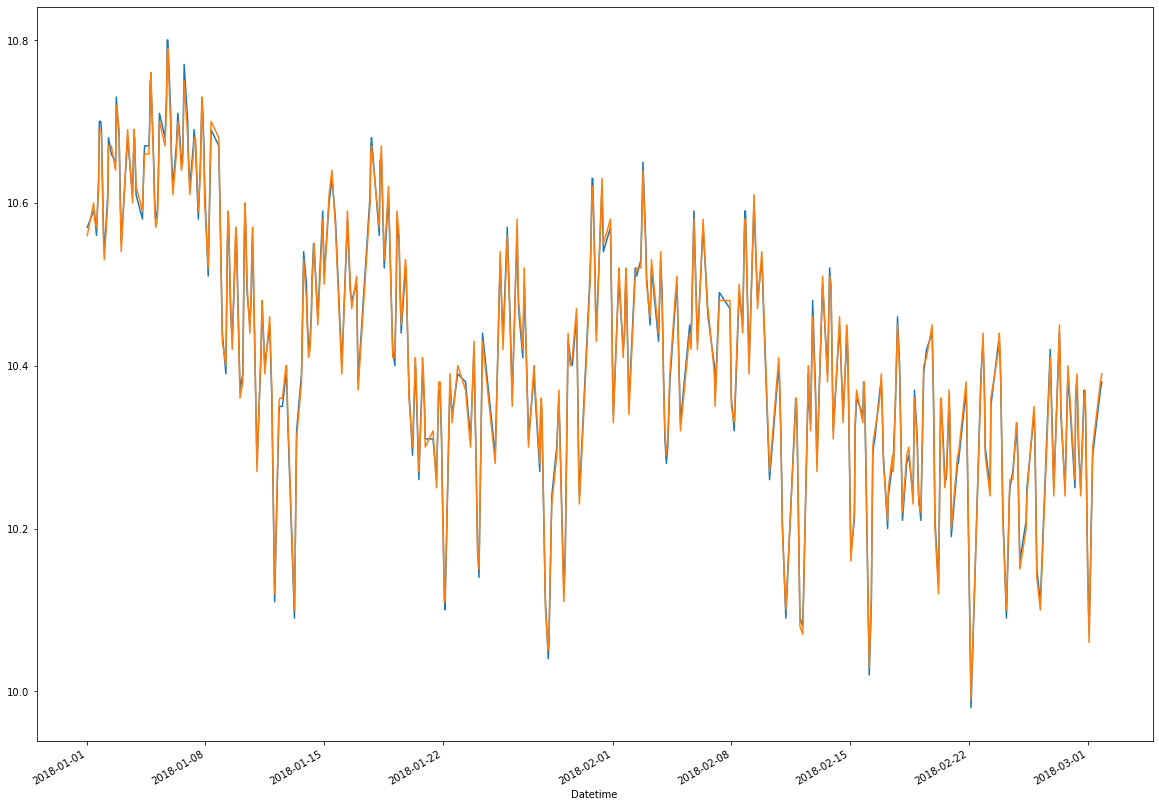

In [40]:
year_2018 = Incorrect_df.loc['2018-01-01':'2018-03-01','True_Y'].plot(figsize=(20,15))
year_2018 = Incorrect_df.loc['2018-01-01':'2018-03-01','Predicted_Y'].plot(figsize=(20,15))

###### Observation:
similary can be seen for 2017 and 2018,for correctly predicted point completely merged,but for incorrectly predicteds the peak and valley of two colors can be clearly seen as they not merged properly on peak and valley<br>
Thus the predicted value is less for peak values as compare to true values<br>
Whereas predicted value id higher for valley values as compare to true values

### 3.Looking the correct and incorrect prediction series for all year by pivoting data

<AxesSubplot:xlabel='Datetime'>

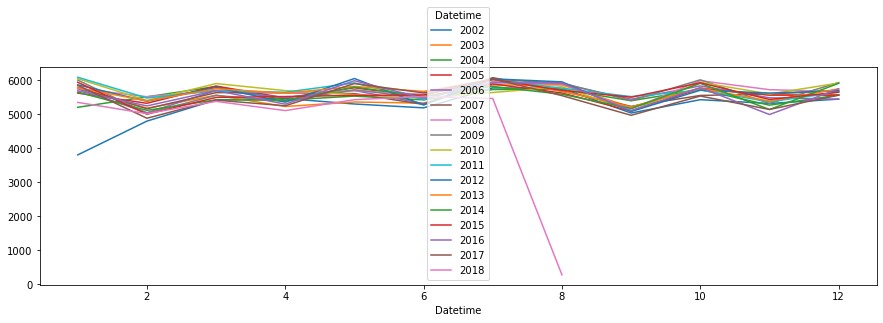

In [42]:
pv = pd.pivot_table(Correct_df, index=Correct_df.index.month, columns=Correct_df.index.year,
                    values='Predicted_Y', aggfunc='sum')
pv.plot(figsize=(15,4))


<AxesSubplot:xlabel='Datetime'>

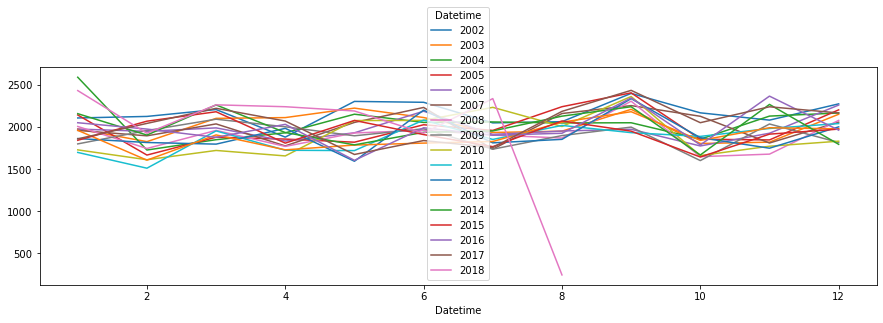

In [43]:
pv1 = pd.pivot_table(Incorrect_df, index=Incorrect_df.index.month, columns=Incorrect_df.index.year,
                    values='Predicted_Y', aggfunc='sum')
pv1.plot(figsize=(15,4))

##### Observation :
We can see the energy consumption plot looks similar for all years for Correctly Predicted dataset ,only difference in magnitude of energy consumption for 2018 as data are not recorded for complete 2018<br>
Whereas the energy consumption a yearly,month,weekly trend not matching at all for incorreclty predicted dataset, just giving random values 

### 4.Distribution of Predicted Variable

##### For Correctly predicted dataset

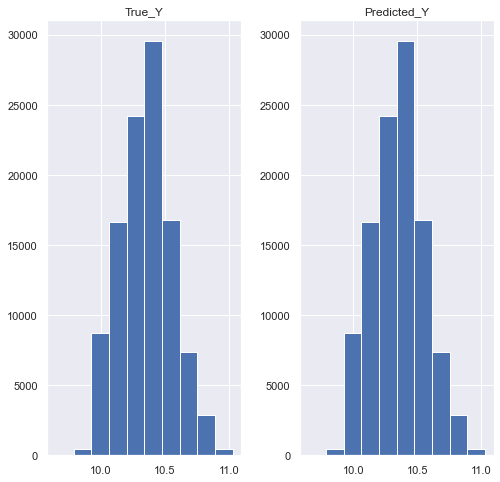

In [81]:
#histogram and density plot
fig, axes = plt.subplots(1, 2)
Correct_df.hist(column="True_Y",ax=axes[0])
Correct_df.hist(column="Predicted_Y",ax=axes[1])
plt.show()

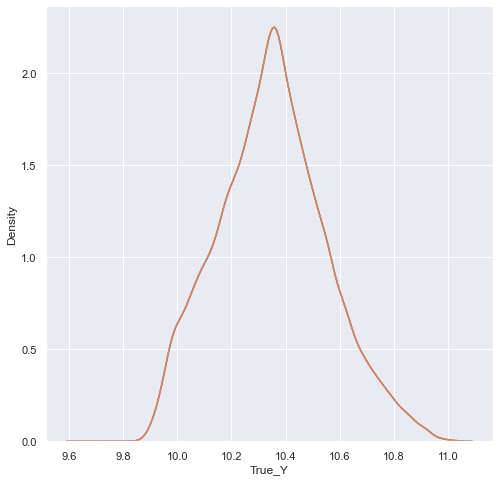

In [79]:
sns.set(rc={'figure.figsize':(8,8)})
sns.kdeplot(x='True_Y', data=Correct_df)
sns.kdeplot(x='Predicted_Y', data=Correct_df)
plt.show()

##### For Incorrectly predicted dataset

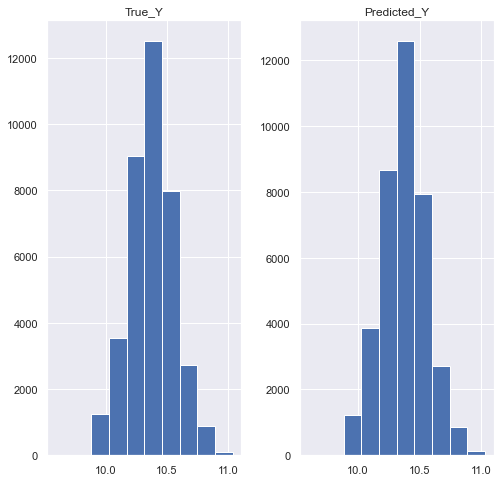

In [80]:
#histogram and density plot
fig, axes = plt.subplots(1, 2)
Incorrect_df.hist(column="True_Y",ax=axes[0])
Incorrect_df.hist(column="Predicted_Y",ax=axes[1])
plt.show()

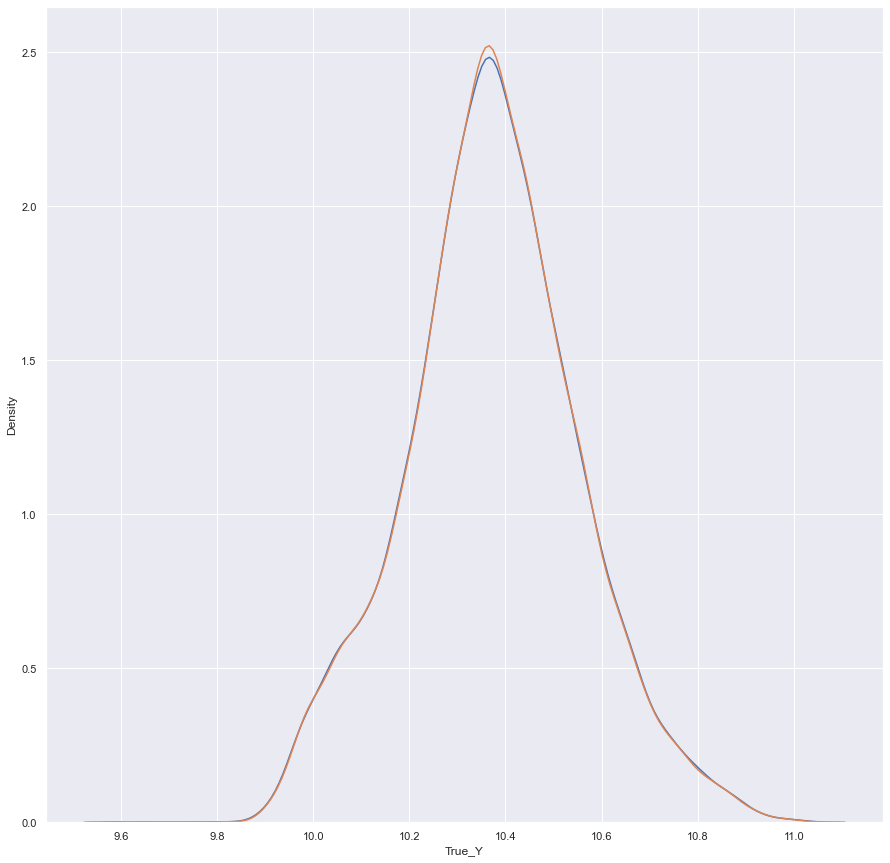

In [82]:
sns.set(rc={'figure.figsize':(15,15)})
sns.kdeplot(x='True_Y', data=Incorrect_df)
sns.kdeplot(x='Predicted_Y', data=Incorrect_df)
plt.show()

##### Observation:
From plots we can see the data is looking  very well distributed for correctly predicted dataset as compare to incorrectly predicted datset.<br>
Also when we look at histogram for incorrectly predicted dataset,the left most portion from mid there is difference in the values of each block which can also be seen in kde plot for confirmation,even peaks of distribution are not matching and having a big gap, while for correctly predicted  kde plot match perfectly